# Mini Project2
Visualize data with set 5 method (no bias)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests

In [2]:
url_dict = {
     'data.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/data.csv',
     'movies.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/movies.csv',
     'train.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/train.csv',
     'test.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/test.csv'
}

def download_file(file_path):
    url = url_dict[file_path]
    print('Start downloading...')
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(file_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024 * 1024 * 1024):
                f.write(chunk)
    print('Complete')

download_file('data.csv')
download_file('movies.csv')
download_file('train.csv')
download_file('test.csv')

Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete


In [3]:
data = np.array(pd.read_csv('data.csv'))
movies = np.array(pd.read_csv('movies.csv'))
train = np.array(pd.read_csv('train.csv'))
test = np.array(pd.read_csv('test.csv'))

In [4]:
def grad_U(Ui, Yij, Vj, reg, eta, mu):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    
    grad = reg*Ui - Vj * ((Yij-mu) - np.dot(Ui,Vj))

    foo = eta*grad

    return foo
        

def grad_V(Vj, Yij, Ui, reg, eta, mu):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """

    grad = reg*Vj - Ui * ((Yij-mu) - np.dot(Ui,Vj))

    foo = eta*grad

    return foo

def get_err(U, V, Y, mu, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """

    N = Y.shape[0]
    err = 0
    for i in range(N):
        Y_idx = Y[i]
        Ui  = U[Y_idx[0]-1,:]
        Vj  = V[Y_idx[1]-1,:]
        Yij = Y_idx[2]

        err += ((Yij-mu) - np.dot(Ui,Vj))**2

    err = err/(2*N)
    err = err + (reg/2)*(np.linalg.norm(U, ord='fro')**2 + np.linalg.norm(V, ord='fro')**2) 

    return err


def train_model(M, N, K, eta, reg, Y, mu, eps=0.0001, max_epochs=300):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV^T)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """

    U = np.random.uniform(-0.5,0.5,size=(M,K)) 
    V = np.random.uniform(-0.5,0.5,size=(N,K))

    err_0 = get_err(U, V, Y, mu, reg=reg) 

    N_y = Y.shape[0]
    
    for c in range(max_epochs):
        j = np.random.permutation(np.array(range(N_y)))
        for i in j:
            Y_idx  = Y[i]
            Ui  = U[Y_idx[0]-1,:]
            Vj  = V[Y_idx[1]-1,:]
            Yij = Y_idx[2]

            Ui = Ui - grad_U(Ui,Yij,Vj, reg, eta, mu)
            Vj  = Vj - grad_V(Vj,Yij,Ui, reg, eta, mu)
        
            U[Y_idx[0]-1,:] = Ui
            V[Y_idx[1]-1,:] = Vj

        err = get_err(U, V, Y, mu, reg=reg)

        if c == 0:
            err_int = np.abs(err-err_0)
            err_1 = 0
        
        err_ratio = (err_1-err)/err_int

        if (err_ratio < eps) and (err_ratio > 0):
            err = get_err(U, V, Y, mu)
            break
        
        err_1 = err

    return U, V, err

## Get final model

In [5]:
data = np.array(pd.read_csv('data.csv'))
movies = np.array(pd.read_csv('movies.csv'))
train = np.array(pd.read_csv('train.csv'))
test = np.array(pd.read_csv('test.csv'))

In [6]:
M = max(max(train[:,0]), max(test[:,0])).astype(int) # users
N = max(max(train[:,1]), max(test[:,1])).astype(int) # movies
print("Factorizing with ", M, " users, ", N, " movies.")
K = 20

reg = 0.1
eta = 0.05
mu_train = np.mean(train[:,2])/train.shape[0]

U,V, err = train_model(M, N, K, eta, reg, train, mu_train, eps=0.005)

Factorizing with  943  users,  1682  movies.


# Visualization 

In [7]:
import VIsualize

## Visualize any 10 movies, part (a)

In [8]:
movie_select = [1, 2, 4, 10, 11, 16, 20, 22, 27, 32] # all thrillers
movie_titles = movies[movie_select] 
movie_titles[:,1]

array(['GoldenEye (1995)', 'Four Rooms (1995)', 'Copycat (1995)',
       'Seven (Se7en) (1995)', 'Usual Suspects, The (1995)',
       'From Dusk Till Dawn (1996)', 'Muppet Treasure Island (1996)',
       'Taxi Driver (1976)', 'Apollo 13 (1995)', 'Desperado (1995)'],
      dtype=object)

GoldenEye (1995)
Four Rooms (1995)
Copycat (1995)
Seven (Se7en) (1995)
Usual Suspects, The (1995)
From Dusk Till Dawn (1996)
Muppet Treasure Island (1996)
Taxi Driver (1976)
Apollo 13 (1995)
Desperado (1995)


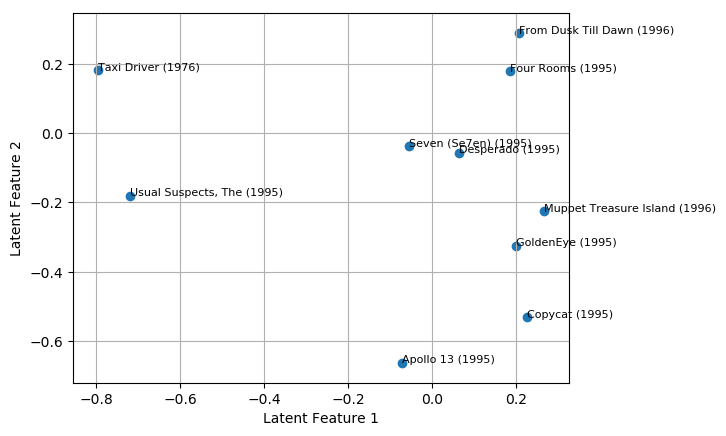

In [9]:
VIsualize.plot(U, V, 'MethodA_figs/Part_a.pdf', movie_select, movie_titles)

# Ten most popular movies, part (b)

In [10]:
#find the ten most popular movie
movie_count = np.zeros(N)
for i in range(len(train)):
    movie_count[int(train[i,1])-1] += 1
movie_count = movie_count/len(train)
movie_idx = np.argsort(movie_count)
movie_idx = movie_idx[::-1]
movie_idx = movie_idx[:10]
movie_idx = movie_idx + 1
movie_idx

array([ 50, 100, 181, 258, 294, 288, 286,   1, 300, 121], dtype=int64)

In [11]:
print("The ten most popular movies are: ")
for i in range(10):
    print(movies[movie_idx[i]-1,1])

The ten most popular movies are: 
Star Wars (1977)
Fargo (1996)
Return of the Jedi (1983)
Contact (1997)
Liar Liar (1997)
Scream (1996)
English Patient, The (1996)
Toy Story (1995)
Air Force One (1997)
Independence Day (ID4) (1996)


Star Wars (1977)
Fargo (1996)
Return of the Jedi (1983)
Contact (1997)
Liar Liar (1997)
Scream (1996)
English Patient, The (1996)
Toy Story (1995)
Air Force One (1997)
Independence Day (ID4) (1996)


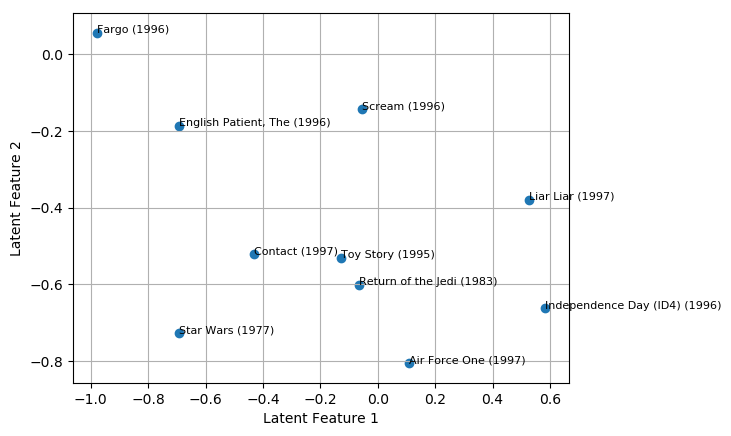

In [12]:
movie_select = movie_idx - 1
movie_titles = movies[movie_select]
VIsualize.plot(U, V, 'MethodA_figs/Part_b_most_popular.pdf', movie_select, movie_titles)

# Ten best movies, part (c)

In [13]:
#find the ten best movies
movie_rating = np.zeros(N)
movie_count = np.zeros(N)
for i in range(len(train)):
    movie_rating[int(train[i,1])-1] += train[i,2]
    movie_count[int(train[i,1])-1] += 1
movie_rating = movie_rating/movie_count
movie_rating[np.isnan(movie_rating)] = 0
movie_idx = np.argsort(movie_rating)
movie_idx = movie_idx[::-1]
movie_idx = movie_idx[:10]

C:\Users\micha\AppData\Local\Temp\ipykernel_30192\607911051.py:7: RuntimeWarning: invalid value encountered in divide
  movie_rating = movie_rating/movie_count


In [14]:
print("The ten best movies are: ")
for i in range(10):
    print(movies[movie_idx[i],1])
    print(movie_rating[movie_idx[i]])

The ten best movies are: 
Great Day in Harlem, A (1994)
5.0
Saint of Fort Washington, The (1993)
5.0
Aiqing wansui (1994)
5.0
Entertaining Angels: The Dorothy Day Story (1996)
5.0
They Made Me a Criminal (1939)
5.0
Prefontaine (1997)
5.0
Santa with Muscles (1996)
5.0
Marlene Dietrich: Shadow and Light (1996) 
5.0
The Deadly Cure (1996)
5.0
Someone Else's America (1995)
5.0


Great Day in Harlem, A (1994)
Saint of Fort Washington, The (1993)
Aiqing wansui (1994)
Entertaining Angels: The Dorothy Day Story (1996)
They Made Me a Criminal (1939)
Prefontaine (1997)
Santa with Muscles (1996)
Marlene Dietrich: Shadow and Light (1996) 
The Deadly Cure (1996)
Someone Else's America (1995)


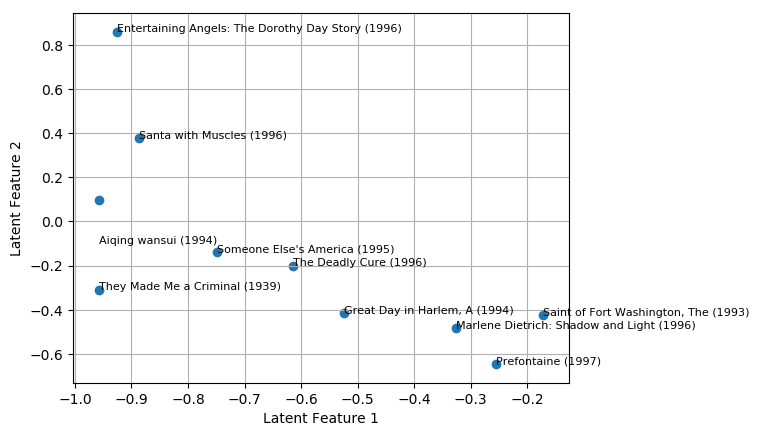

In [15]:
# Get the plot
movie_select = movie_idx
movie_titles = movies[movie_select]
VIsualize.plot(U, V, 'MethodA_figs/Part_c_best_movies.pdf', movie_select, movie_titles, "Aiqing wansui (1994)", 0.0, -0.2)

# Ten movies from three genres

In [16]:
# Choose the genres Sci-Fi, Comedy, and Adventure, and find the corresponding movies and put them into separate lists
genres = ['Sci-Fi', 'Comedy', 'Adventure']
data = pd.read_csv('data.csv')
movies = pd.read_csv('movies.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

genres = ['Sci-Fi', 'Comedy', 'Adventure']
movies_genres = movies[movies[genres].sum(axis=1) > 0]
print(movies_genres[['Movie ID', 'Movie Title', 'Sci-Fi', 'Comedy', 'Adventure']])


      Movie ID                      Movie Title  Sci-Fi  Comedy  Adventure
0            1                 Toy Story (1995)       0       1          0
1            2                 GoldenEye (1995)       0       0          1
3            4                Get Shorty (1995)       0       1          0
6            7            Twelve Monkeys (1995)       1       0          0
7            8                      Babe (1995)       0       1          0
...        ...                              ...     ...     ...        ...
1658      1659  Getting Away With Murder (1996)       0       1          0
1663      1664   8 Heads in a Duffel Bag (1997)       0       1          0
1667      1668        Wedding Bell Blues (1996)       0       1          0
1669      1670                   Tainted (1998)       0       1          0
1680      1681              You So Crazy (1994)       0       1          0

[679 rows x 5 columns]


### Sci-Fi

Twelve Monkeys (1995)
Net, The (1995)
Strange Days (1995)
Star Wars (1977)
Stargate (1994)
Jurassic Park (1993)
Robert A. Heinlein's The Puppet Masters (1994)
Blade Runner (1982)
Terminator 2: Judgment Day (1991)
Heavy Metal (1981)


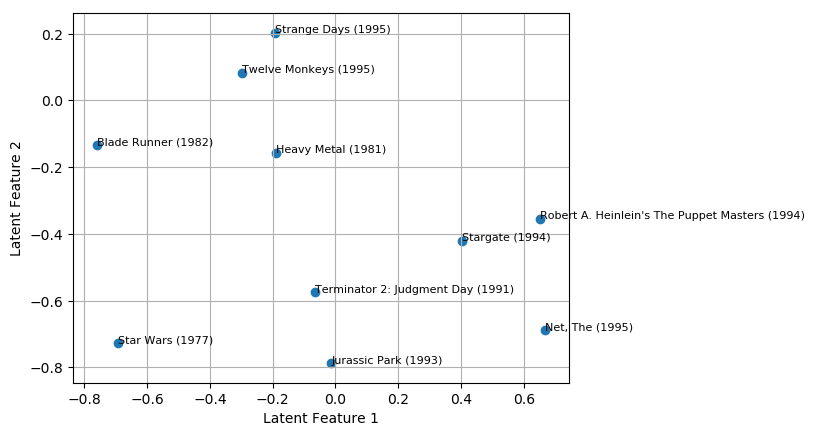

In [17]:
# Get 10 of the sci-fi movies
data_arr = np.array(pd.read_csv('data.csv'))
movies_arr = np.array(pd.read_csv('movies.csv'))
train_arr = np.array(pd.read_csv('train.csv'))
test_arr = np.array(pd.read_csv('test.csv'))

movie_select = movies_genres[movies_genres['Sci-Fi'] == 1]['Movie ID']
movie_select = movie_select[:10]
movie_select = movie_select.to_numpy()
movie_titles = movies_arr[movie_select-1]
VIsualize.plot(U, V, 'MethodA_figs/Part_d_Sci-Fi.pdf', movie_select-1, movie_titles)

### Comedy

Toy Story (1995)
Get Shorty (1995)
Babe (1995)
Mighty Aphrodite (1995)
French Twist (Gazon maudit) (1995)
From Dusk Till Dawn (1996)
Muppet Treasure Island (1996)
Birdcage, The (1996)
Brothers McMullen, The (1995)
Batman Forever (1995)


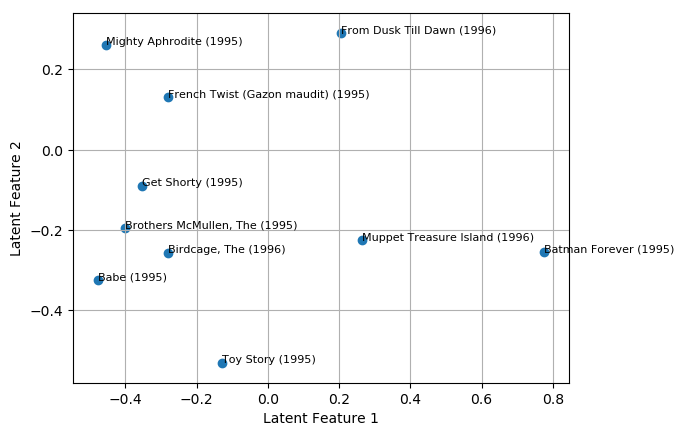

In [18]:
# Get 10 of the comedy movies
movie_select = movies_genres[movies_genres['Comedy'] == 1]['Movie ID']
movie_select = movie_select[:10]
movie_select = movie_select.to_numpy()
movie_titles = movies_arr[movie_select-1]
VIsualize.plot(U, V, 'MethodA_figs/Part_d_Comedy.pdf', movie_select-1, movie_titles)

### Adventure

GoldenEye (1995)
Muppet Treasure Island (1996)
Rumble in the Bronx (1995)
Batman Forever (1995)
Free Willy 2: The Adventure Home (1995)
Star Wars (1977)
Stargate (1994)
Free Willy (1993)
Jurassic Park (1993)
Dances with Wolves (1990)


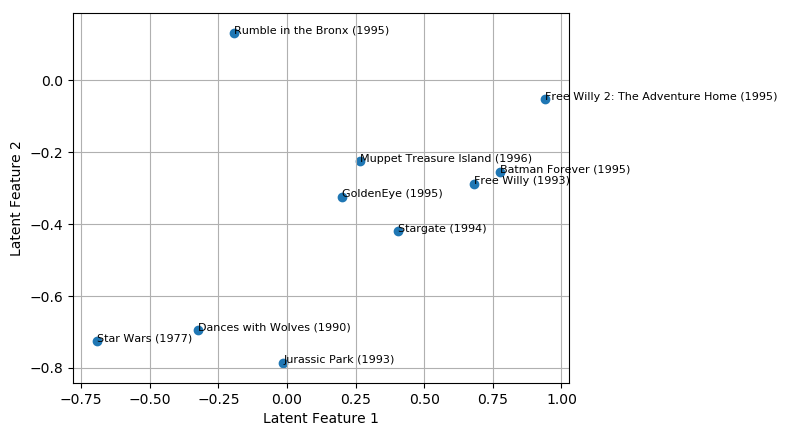

In [19]:
# Get 10 of the adventure movies
movie_select = movies_genres[movies_genres['Adventure'] == 1]['Movie ID']
movie_select = movie_select[:10]
movie_select = movie_select.to_numpy()
movie_titles = movies_arr[movie_select-1]
VIsualize.plot(U, V, 'MethodA_figs/Part_d_Adventure.pdf', movie_select-1, movie_titles)